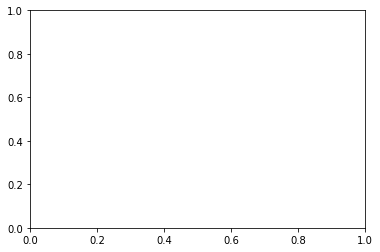

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from main import measure
from helper import view, view_phase

# Setup
## Load the sample

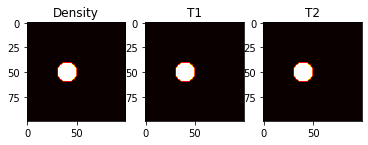

In [2]:
sample = np.load(f"{os.getcwd()}/sample.npy")
view(sample)

## Setup magnetic field
It is necessary to add some noise to the magnetic field. Otherwise, the magnetic
field will be perfectly homogenous, which is unrealistic. Furthermore, is a slight
inhomogeneity in the magnetic field necessary for spin echos.

In [3]:
b0 = np.zeros(sample.shape[:2])
b0.fill(0.43)
b0 += np.random.normal(0, 0.01, b0.shape)

Setup phases and measurement time

Summation of the waiting time between the $$90^\circ$$ pulses:
$$\sum_{i=1}^n t_{rec} \cdot i = t_{rec} \cdot \sum_{i=1}^n i = t_{rec} \cdot \frac{n^2+n}{2}$$

In [ ]:
pause_time = 1000  # ms  Time between the different measurements
echo_time = 5  # ms  Has to be smaller than pause_time / 2
recovery_time_step = 5  # ms  Time between the 90 degree pulses
points = 100
tfactor = 2  # how many steps per 1ms

t = pause_time * points + recovery_time_step * (points**2 + points) // 2 # ms

# phases = [Gradx, Grady, Gradz, Pulse]
phases = np.zeros((t * tfactor, 4))
time = 0
for i in range(points):
    phases[tfactor * time, 3] = np.pi / 2  # first 90 degree pulse
    time += recovery_time_step * (i + 1)
    phases[tfactor * time, 3] = np.pi / 2  # sec 90 degree pulse
    phases[tfactor * (time + echo_time), 3] = np.pi
    time += pause_time

view_phase(phases, tfactor)


# Measure

In [ ]:
ts = np.linspace(0, t, t * tfactor, True)
signal = measure(sample, b0, tfactor, phases)

plt.plot(ts, signal)
plt.show()

# Results
Fit exponential function to determine t1